In [1]:
import glob
import json
import os
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np
import torch
from bouncing_ball.dataloaders.bouncing_data import BouncingBallDataLoader
from IPython.display import Video
from kalman_vae import KalmanVariationalAutoencoder
from natsort import natsorted
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
checkpoint_dir = "checkpoints/bouncing_ball_vae"

In [3]:
os.makedirs(checkpoint_dir, exist_ok=True)

In [4]:
# fix random seeds for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
_dataloader_train = BouncingBallDataLoader(
    root_dir="bouncing_ball/datasets/bouncing-ball/train"
)
_dataloader_test = BouncingBallDataLoader(
    root_dir="bouncing_ball/datasets/bouncing-ball/test"
)

In [6]:
def sequence_first_collate_fn(batch):
    data = torch.Tensor(np.stack(batch, axis=0))
    # data.shape: [batch size, sequence length, channels, height, width]
    # Reshape to [sequence length, batch size, channels, height, width]
    data = data.permute(1, 0, 2, 3, 4)
    return data

In [7]:
dataloader_train = DataLoader(
    _dataloader_train,
    batch_size=128,
    shuffle=True,
    collate_fn=sequence_first_collate_fn,
)
dataloader_test = DataLoader(
    _dataloader_test, batch_size=128, shuffle=True, collate_fn=sequence_first_collate_fn
)

In [8]:
for i, data in enumerate(dataloader_train):
    print(data.shape)
    # To Float32
    data = (data > 0.5).float()
    break

torch.Size([50, 128, 1, 16, 16])


In [9]:
kvae = KalmanVariationalAutoencoder(
    image_size=data.shape[3:],
    image_channels=data.shape[2],
    a_dim=2,
    z_dim=4,
    K=3,
    decoder_type="bernoulli",
)

In [10]:
optimizer = torch.optim.Adam(kvae.parameters(), lr=1e-3)

In [11]:
def find_latest_checkpoint_index(pattern):
    files = glob.glob(pattern)
    if files:
        return int(
            max(files, key=lambda x: int(x.split("-")[-1].split(".")[0]))
            .split("-")[-1]
            .split(".")[0]
        )
    return None


latest_index = find_latest_checkpoint_index(os.path.join(checkpoint_dir, "state-*.pth"))

if latest_index is not None:
    checkpoint = torch.load(os.path.join(checkpoint_dir, f"state-{latest_index}.pth"))
    kvae.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch_start = checkpoint["epoch"] + 1
    print("Loaded checkpoint at epoch {}".format(latest_index))
else:
    epoch_start = 0

Loaded checkpoint at epoch 19


In [12]:
p = tqdm(range(epoch_start, 20))
for epoch in p:
    kvae.train()
    losses = []
    for i, data in enumerate(dataloader_train):
        data = (data > 0.5).float()
        optimizer.zero_grad()
        elbo, info = kvae.elbo(
            data,
            learn_weight_model=False,
            reconst_weight=1.0,
            regularization_weight=0.0,
            kalman_weight=0.0,
            kl_weight=1.0,
        )
        loss = -elbo
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        p.set_description(
            f"Train Epoch {epoch}, Batch {i}/{len(dataloader_train)}, Loss {loss.item()}"
        )
    train_loss = sum(losses) / len(losses)

    # Test
    kvae.eval()
    losses = []
    for i, data in enumerate(dataloader_test):
        data = (data > 0.5).float()
        elbo, info = kvae.elbo(
            data,
            learn_weight_model=False,
            reconst_weight=1.0,
            regularization_weight=0.0,
            kalman_weight=0.0,
            kl_weight=1.0,
        )
        loss = -elbo
        losses.append(loss.item())
        p.set_description(
            f"Test Epoch {epoch}, Batch {i}/{len(dataloader_test)}, Loss {loss.item()}"
        )

    test_loss = sum(losses) / len(losses)

    # Save
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": kvae.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss": train_loss,
            "test_loss": test_loss,
        },
        os.path.join(checkpoint_dir, f"state-{epoch}.pth"),
    )

0it [00:00, ?it/s]


# Result analysis

## Loss

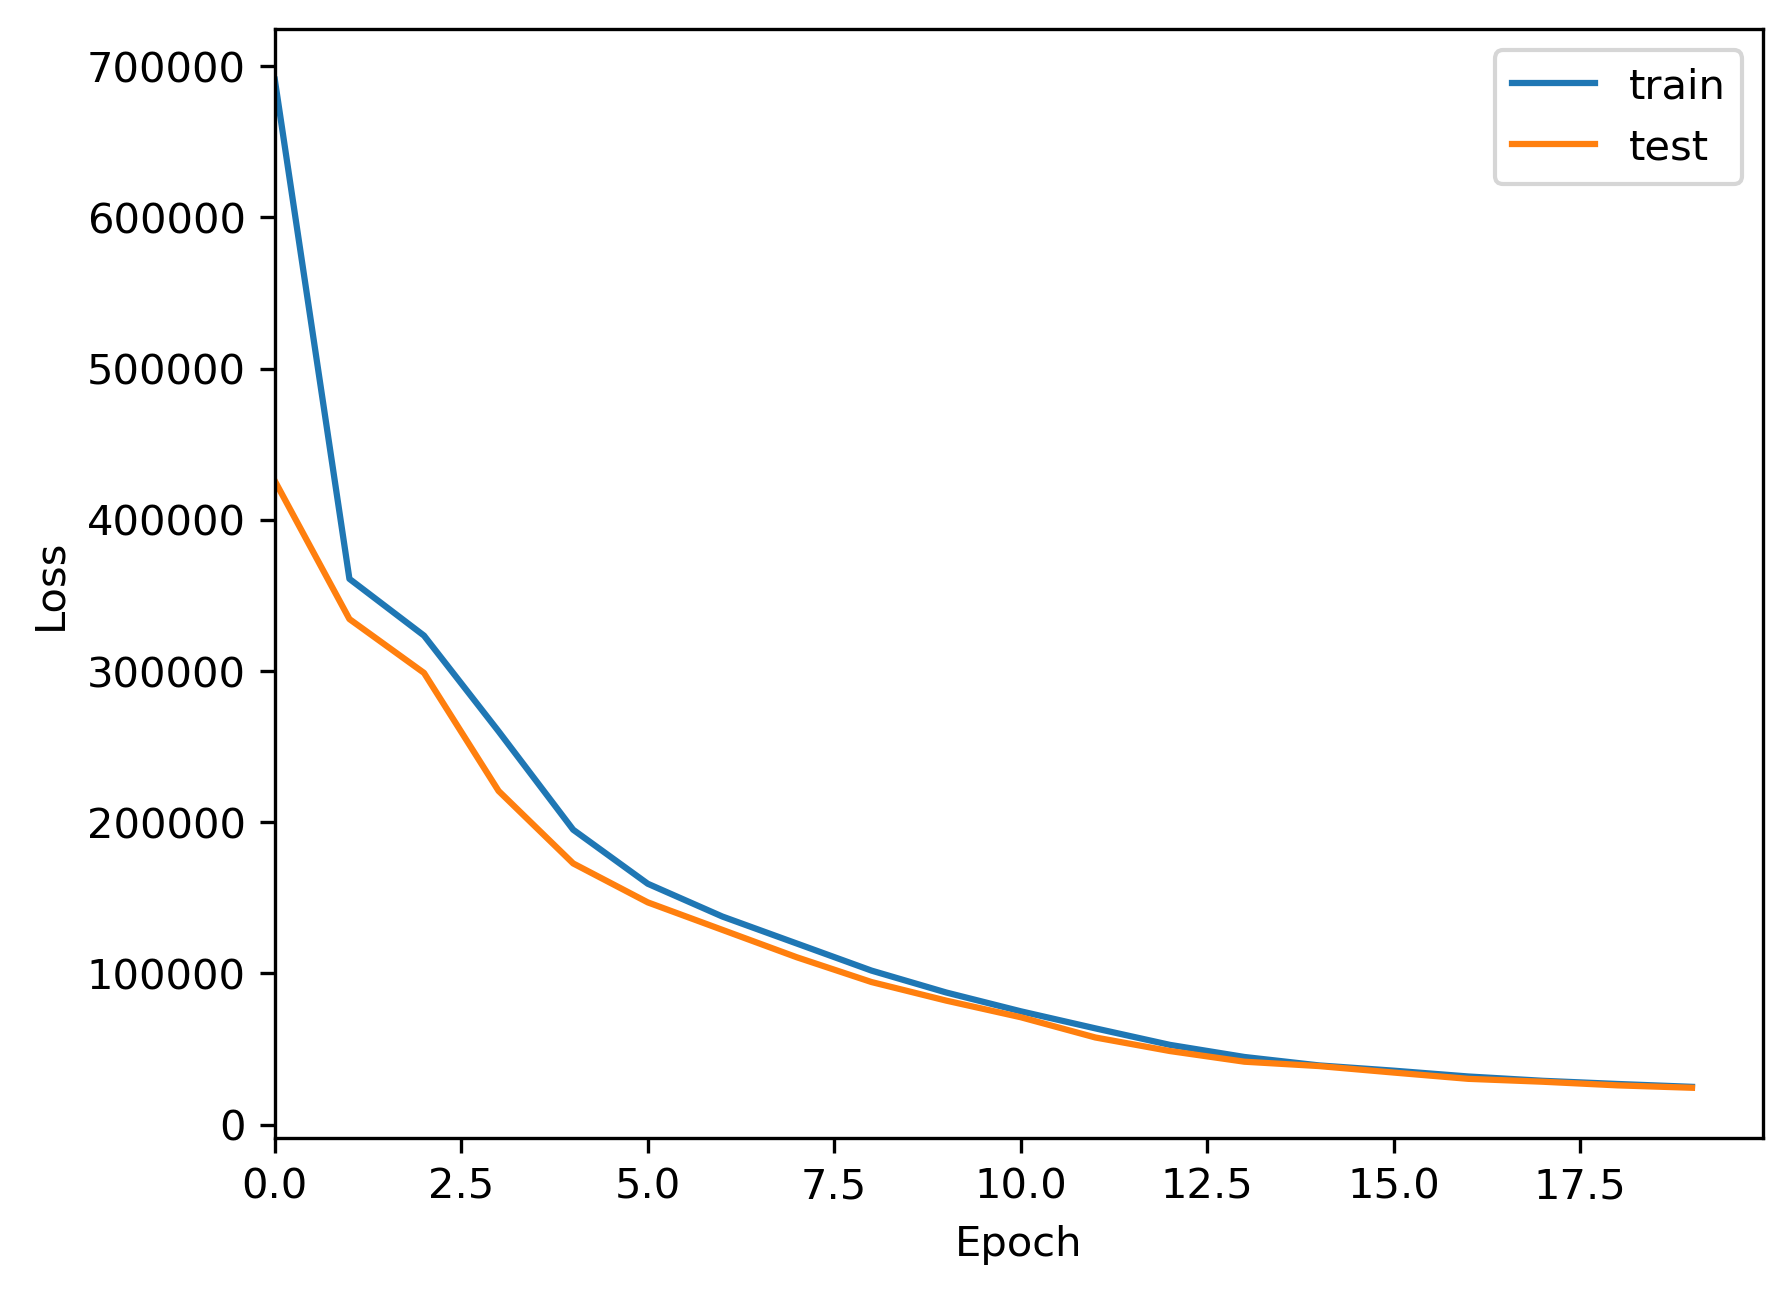

In [13]:
train_losses = []
test_losses = []

for file in natsorted(glob.glob("checkpoints/bouncing_ball_vae/state-*.pth")):
    checkpoint = torch.load(file)
    train_losses.append(checkpoint["train_loss"])
    test_losses.append(checkpoint["test_loss"])

plt.figure(dpi=300)
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xlim(0, None)
# plt.yscale("log")
plt.show()

## Reconstruction

In [14]:
checkpoint = torch.load(file)

In [15]:
def sequence_first_collate_fn(batch):
    data = torch.Tensor(np.stack(batch, axis=0))
    # data.shape: [batch size, sequence length, channels, height, width]
    # Reshape to [sequence length, batch size, channels, height, width]
    data = data.permute(1, 0, 2, 3, 4)
    return data

In [16]:
dataloader_test = DataLoader(
    _dataloader_test, batch_size=5, shuffle=False, collate_fn=sequence_first_collate_fn
)

In [17]:
for i, data in enumerate(dataloader_test):
    print(data.shape)
    # To Float32
    data = (data > 0.5).float()
    break

torch.Size([50, 5, 1, 16, 16])


In [18]:
image_size = data.shape[-2:]
image_channels = data.shape[-3]

In [19]:
kvae = KalmanVariationalAutoencoder(
    image_size=image_size,
    image_channels=image_channels,
    a_dim=2,
    z_dim=4,
    K=3,
    decoder_type="bernoulli",
)

In [20]:
kvae.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [21]:
data_flatten = data.permute(1, 0, 2, 3, 4).reshape(-1, image_channels, *image_size)

In [22]:
as_dist = kvae.encoder(data_flatten)

In [23]:
reconstructions = kvae.decoder(as_dist.sample()).probs

In [24]:
# Save images in temporary dir
with TemporaryDirectory() as tmpdirname:
    for i, (input_image, reconstruction) in enumerate(
        tqdm(
            zip(data_flatten.detach().numpy(), reconstructions.detach().numpy()),
            total=len(data_flatten),
        )
    ):
        fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100)
        ax1.imshow(input_image[0], cmap="Greys")
        ax1.set_title("Input")
        ax2.imshow(reconstruction[0], cmap="Greys")
        ax2.set_title("Reconstruction")
        plt.savefig(os.path.join(tmpdirname, f"{i}.png"))
        plt.close()

    # Create video (openh264)
    os.system(
        f"ffmpeg -r 10 -i {tmpdirname}/%d.png -vcodec libopenh264 -y -r 10 bouncing_ball_vae.mp4"
    )

100%|██████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:22<00:00, 10.88it/s]
ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566251848/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566251848/_build_env/bin/x86_64-apple-darwin13.4.0-cl

In [25]:
Video("bouncing_ball_vae.mp4")